In [32]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(dplyr)
library(circlize)
library(ggrepel)
library(igraph)
library(ggExtra)
library(tidyverse)
library(ggsci)

options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
fold_notebook <- 'castom_cad_scz/jupyter_notebook/'
functR <- sprintf('%sFunctions_prediction_plots.R',fold_notebook)
source(functR)

color_file <- sprintf('%scolor_tissues.txt', fold_notebook)
fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/'
fold_random <- paste0(fold, 'random_cluster/')
out_fold <- sprintf('%sCAD_clustering/', fold_notebook)

cl_res <- get(load(sprintf('%stscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', fold)))
cl_genes <- get(load(sprintf('%stscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))
# cl_genes_loci <- read.table(sprintf('%stscore_corrPCs_zscaled_clusterCases_summary_geneLoci_allTissues.txt', fold), header = T, stringsAsFactors = F)
cl_pathways <- get(load(sprintf('%spathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))
cl_endophenotype <- read.delim(sprintf('%stscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined.txt', fold), h=T, stringsAsFactors = F)
cl_endophenotype_HD <- read.delim(sprintf('%snominalAnalysis_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM.txt', fold), h=T, stringsAsFactors = F)
cl_drug_response <- read.delim(sprintf('%swithMedication_tscore_corrPCs_zscaled_clusterCases_TreatResponse_pairwise.txt', fold), h=T, stringsAsFactors = F)

pval_FDR <- 0.05



[1] "C"

In [33]:
# Number of tested elements:
# endophenotypes
sum(!is.na(unique(cl_endophenotype$pheno_id)))
table(cl_endophenotype$pheno_type[!duplicated(cl_endophenotype$pheno_id)])
# hypothesis driven endophenotypes
sum(!is.na(unique(cl_endophenotype_HD$pheno_id)))

# drug response
sum(!is.na(unique(cl_drug_response$pheno_id)))
sum(!is.na(unique(cl_drug_response$treat_id)))
# comination drug response
cl_drug_response$combination <- paste(cl_drug_response$treat_id, cl_drug_response$pheno_id, sep = '_')
sum(!is.na(unique(cl_drug_response$combination)))
table(cl_drug_response$pheno_class[!duplicated(cl_drug_response$pheno_id)])
# genes
sum(sapply(cl_genes$test_feat, function(x) length(unique(x$feat))))
sum(sapply(cl_pathways$test_feat, function(x) length(unique(x$feat))))

cl_genes <- do.call(rbind, cl_genes$test_feat)
cl_pathways <- do.call(rbind, cl_pathways$test_feat)


[1] 637


           Alcohol Arterial_stiffness Blood_biochemistry        Blood_count 
                26                  8                 30                 31 
 Blood_count_ratio     Blood_pressure Body_size_measures               Diet 
                 4                  5                  4                 57 
Early_life_factors     Family_history Hand_grip_strength     Height_derived 
                 2                 54                  2                  1 
     ICD9-10_OPCS4 Impedance_measures         Medication        Medications 
               103                  5                 32                196 
 Physical_activity              Sleep            Smoking 
                31                  7                 39 

[1] 33

[1] 87

[1] 17

[1] 1479


Arterial_stiffness Blood_biochemistry        Blood_count  Blood_count_ratio 
                 8                 30                 29                  4 
    Blood_pressure Body_size_measures Hand_grip_strength Impedance_measures 
                 5                  4                  2                  5 

[1] 36397

[1] 7978

General count summary:
- 637 endophenotypes tested across 19 categories (UKBB)
- 33 endophenotypes tested hypothesis driven
- 87 endophenotypes in treatment response across 8 categories wrt 17 treatments for a total of 1479 combinations
- across 11 tissues, 36397 genes and 7978 filtered pathway with Jaccard 0.2 (Reactome and GO) tested

In [34]:
# load random clustering results
n_rep <- 50
n_rep_short <- 10

cl_res_r <- cl_endophenotype_r <- cl_endophenotype_HD_r <- cl_drug_response_r <- list()

for(i in 1:n_rep){

    cl_res_r[[i]] <- get(load(sprintf('%stscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_rep%i.RData', 
                                      fold_random, i)))
    cl_res_r[[i]] <- cl_res_r[[i]]$cl_best
    
    cl_endophenotype_r[[i]] <- read.delim(sprintf('%srep%i_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined.txt', fold_random, i), h=T, stringsAsFactors = F)
    cl_endophenotype_HD_r[[i]] <- read.delim(sprintf('%srep%i_nominalAnalysis_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM.txt', fold_random, i), h=T, stringsAsFactors = F)
    cl_drug_response_r[[i]] <- read.delim(sprintf('%srep%i_withMedication_tscore_corrPCs_zscaled_clusterCases_TreatResponse_pairwise.txt', fold_random, i), h=T, stringsAsFactors = F)

}


,rep,NMI,chisqtest,BHcorr,log10p,id_plot
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4,4,0.0005647929,0.01239669,0.5303934,1.906694,Rep 4
29,29,0.0005058746,0.02318601,0.5303934,1.634774,Rep 29
1,1,0.0005007569,0.03182360,0.5303934,1.497251,Rep 1
31,31,0.0004791464,0.04259363,0.5324204,1.370655,Rep 31


Warning message:
“Removed 46 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 46 rows containing missing values (geom_text_repel).”


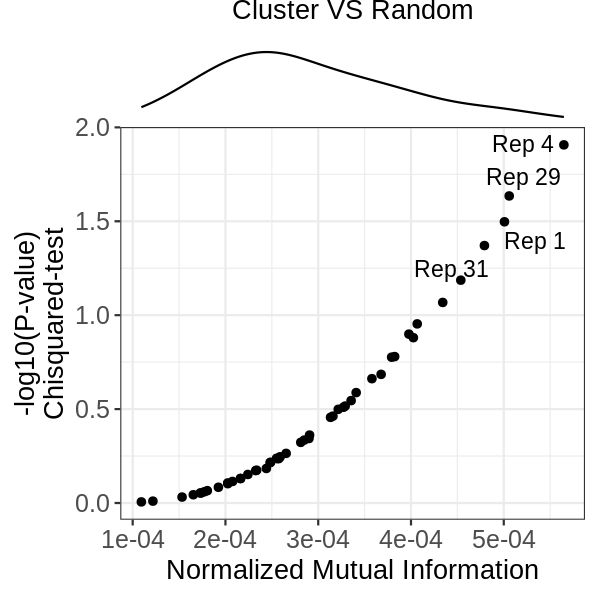

In [35]:
# NMI real and random phenotype:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 150)

df_comp <- data.frame(rep = 1:n_rep, 
                      NMI = sapply(cl_res_r, function(x) compare(x$gr, cl_res$cl_best$gr, method = 'nmi')), 
                      chisqtest = sapply(cl_res_r, function(x) 
                          chisq.test(table(x$gr, cl_res$cl_best$gr))$p.value))
df_comp$BHcorr <- p.adjust(df_comp$chisqtest, method = 'BH')
df_comp$log10p <- -log10(df_comp$chisqtest)
df_comp$id_plot <- paste0("Rep ", 1:n_rep)
df_comp$id_plot[df_comp$log10p < -log10(0.05)] <- NA
df_comp[order(df_comp$log10p, decreasing = T)[1:sum(!is.na(df_comp$id_plot))],]
        
pl <- ggplot(df_comp, aes(x = NMI, y = log10p, label = id_plot))+
        geom_point(size = 1.5) + 
        geom_text_repel(max.overlaps = Inf, force  = 20)+
        theme_bw() + 
        ggtitle("Cluster VS Random")+    
        ylab('-log10(P-value)\nChisquared-test') + xlab('Normalized Mutual Information')+
        theme(plot.title = element_text(hjust = 0.5, size = 13), axis.text = element_text(size = 12), 
             axis.title = element_text(size = 13))

pl <- ggMarginal(pl, type="density", margins = "x")
pl
                                         
ggsave(plot = pl, filename = sprintf('%s/NMI_chisqtest_randomCL.pdf', out_fold), width = 4, height = 4.2)



Among 50 repetitions, 4 rep reaches a p-value < 0.05 (min p = 0.01) but not significant after FDR correction (0.53), hence there is no overlap among the structures

In [56]:
# Compare endophenotype
comp <- unique(cl_endophenotype$comp)
gr_color <- pal_d3(palette = 'category20')(length(comp))

create_df_volcano_plot <- function(real_cl, random_cl){
    
    comp <- unique(real_cl$comp)
    thr <- c()
    df_plot <- list()

    for(j in 1:length(comp)){

        group_endo <- real_cl[real_cl$comp == comp[j],]
        group_endo <- group_endo[order(group_endo$pvalue), ]
        group_endo <- group_endo[!is.na(group_endo$pvalue), ]
        group_endo_random <- lapply(random_cl, function(x) x[x$comp == comp[j],])
        group_endo_random <- lapply(group_endo_random, function(x) x[!is.na(x$pvalue),])
        group_endo_random <- lapply(group_endo_random, function(x) x[order(x$pvalue),])

        # summary count
        min_p <- sapply(group_endo_random, function(x) min(x$pvalue, na.rm = T))
        group_endo$pval_perm <- sapply(group_endo$pvalue, function(x) sum(x > min_p)/n_rep)                              
        thr <- c(thr, max(group_endo$pvalue[group_endo$pval_perm <= 0.1]))
                                      
        df_group <- data.frame(P = c(unlist(lapply(group_endo_random, function(x) x$pvalue)), group_endo$pvalue), 
                                pheno_id = c(unlist(lapply(group_endo_random, function(x) x$pheno_id)), group_endo$pheno_id), 
                               index = c( unlist(lapply(group_endo_random, function(x) 1:nrow(x))), 1:nrow(group_endo)), 
                               beta = c(unlist(lapply(group_endo_random, function(x) x$beta)), group_endo$beta), 
                               se_beta = c(unlist(lapply(group_endo_random, function(x) x$se_beta)), group_endo$se_beta), 
                               type = c(unlist(mapply(function(x, y) rep(sprintf('Random %i', x), nrow(y)), 
                                                     x = 1:n_rep, y = group_endo_random, SIMPLIFY = F)), rep('Real group', nrow(group_endo))),
                               type_s =  c(rep('Random group', sum(sapply(group_endo_random, nrow))), 
                                           rep('Real group', nrow(group_endo))), 
                               FDR_5 = c(unlist(lapply(group_endo_random, function(x) x$pval_corr <= 0.05)),
                                                      group_endo$pval_corr <= 0.05), 
                               nominal_1 = c(unlist(lapply(group_endo_random, function(x) x$pvalue <= 0.01)),
                                                      group_endo$pvalue <= 0.01), 
                               perm = NA)
        df_group$perm[df_group$type_s == "Real group"] <- group_endo$pval_perm
                                           
       df_group$log10p <- -log10(df_group$P)
       df_group <- df_group[!is.na(df_group$P), ]
       df_group$type_s <- factor(df_group$type_s, levels = c('Real group', 'Random group'))
       df_group$FDR_5 <- factor(as.character(df_group$FDR_5), levels = c("TRUE", "FALSE"))
       df_group$nominal_1 <- factor(as.character(df_group$nominal_1), levels = c("TRUE", "FALSE"))
       
       df_group$gr <- strsplit(comp[j], split = "_vs_all")[[1]]
       df_plot[[j]] <- df_group
    }
    df_plot <- do.call(rbind, df_plot)
    df_thr <- data.frame(gr = unique(df_plot$gr), thr = thr, log10 = -log10(thr))
                                      
    return(list(plot = df_plot, thr = df_thr))

}


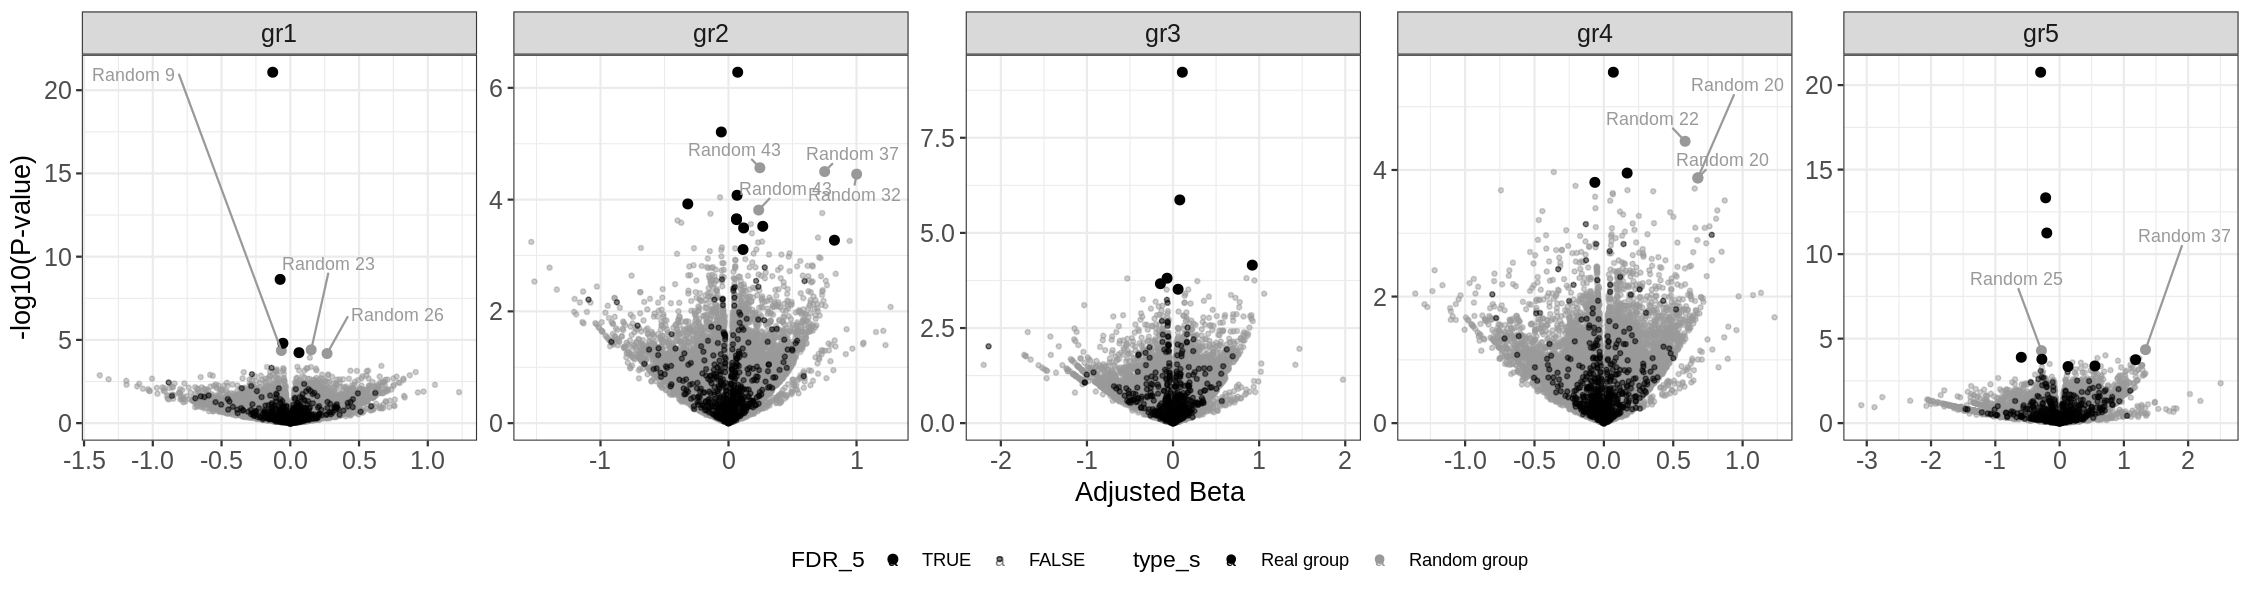

In [57]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 150)

df <- create_df_volcano_plot(real_cl = cl_endophenotype, random_cl = cl_endophenotype_r)

df$plot$label_plot <- ""
id <- as.logical(as.character(df$plot$FDR_5)) & (as.character(df$plot$type_s) == "Random group")
df$plot$label_plot[id] <- df$plot$type[id]

pl <- ggplot(subset(df$plot, abs(beta) < 5), aes(x = beta, y = log10p, color = type_s, 
                           alpha = FDR_5, size = FDR_5, label = label_plot))+
        #geom_hline(data = df$thr, aes(yintercept = log10), linetype = "dashed", color = "red")+ 
        # geom_hline(yintercept = min(df$thr$log10), linetype = "dashed", color = "red")+ 
        geom_point() + 
        facet_wrap(gr~., nrow = 1, scales = "free")+
        geom_text_repel(size = 3, force = 100, max.overlaps = Inf, min.segment.length = 0) + 
        theme_bw() + 
        scale_alpha_manual(values = c(1, 0.5))+
        scale_size_manual(values = c(1.8, 0.8))+
        xlab("Adjusted Beta") + ylab("-log10(P-value)")+
        scale_color_manual(values = c("black", "grey60"))+
        theme(legend.position = "bottom", strip.text = element_text(size = 12),
              plot.title = element_text(hjust = 0.5, size = 13), axis.text = element_text(size = 12), 
             axis.title = element_text(size = 13))

pl

pl <- ggplot_gtable(ggplot_build(pl))
stripr <- which(grepl('strip-t', pl$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}
ggsave(filename = sprintf('%s/volcanoPlot_endopheno_randomCL_noperm.png', out_fold), width = 15, height = 4.2, dpi = 200, plot = pl, device = 'png') 



- How many False Positive? Results significant at FDR 0.05 that do not pass Permutation threshold 0.1
- How many Random association are significant at 0.05 FDR thr?

In [60]:
r_sign <- df$plot[df$plot$FDR_5 == "TRUE" & df$plot$type_s == 'Random group',]
table(r_sign$type)
table(df$plot$FDR_5, df$plot$type_s)
table(df$plot$FDR_5 == "TRUE", df$plot$perm < 0.1)

a = cl_endophenotype[order(cl_endophenotype$pvalue),]
a <- a[!is.na(a$pvalue),]
a[a$pval_corr <= 0.05 & a$pvalue > 3e-04,]
df$thr



Random 20 Random 22 Random 23 Random 25 Random 26 Random 32 Random 37 Random 43 
        2         1         1         1         1         1         2         2 
 Random 9 
        1 

       
        Real group Random group
  TRUE          31           12
  FALSE       3137       158346

       
        FALSE TRUE
  FALSE  3137    0
  TRUE     10   21

,pheno_id,Field,meaning,beta,se_beta,z,pvalue,OR_or_Beta,CI_low,CI_up,type_pheno,pval_corr,comp,pval_corr_overall,pheno_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1985,6153_1,"Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones",Cholesterol lowering medication,0.26765068,0.07403872,3.615010,0.0003003362,1.30689054,1.13036147,1.51098824,CAT_MUL_BINARY_VAR,0.02549776,gr2_vs_all,0.5934252,Medication
508,30690,Cholesterol,NA,0.05888194,0.01629466,3.613573,0.0003028458,0.05888194,0.02694499,0.09081889,CONTINUOUS,0.03205118,gr3_vs_all,0.1588975,Blood_biochemistry
295,30150,Eosinophill count,NA,0.11799705,0.03279294,3.598245,0.0003212316,1.12524079,1.05519340,1.19993817,CAT_ORD,0.02549776,gr2_vs_all,0.1596734,Blood_count
3148,6153_100,"Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones",None of the above,0.54936223,0.15555498,3.531627,0.0004130108,1.73214796,1.27695722,2.34959833,CAT_MUL_BINARY_VAR,0.03517415,gr5_vs_all,0.7253827,Medication
1051,30270,Mean sphered cell volume,NA,0.13159407,0.03747945,3.511099,0.0004473660,0.13159407,0.05813570,0.20505244,CONTINUOUS,0.03517415,gr5_vs_all,0.2112520,Blood_count
1932,20003_1140883568,Treatment/medication code,oxybutynin,0.82759822,0.23894085,3.463611,0.0005329761,2.28781731,1.43230174,3.65433336,CAT_MUL_BINARY_VAR,0.03760443,gr2_vs_all,0.7658847,Medications
1695,41270_I20,Diagnoses - ICD10,I20 Angina pectoris,0.11351872,0.03379422,3.359117,0.0007819200,1.12021286,1.04841896,1.19692308,CAT_SINGLE_UNORDERED,0.04965192,gr2_vs_all,0.9320685,ICD9-10_OPCS4


gr,thr,log10
<chr>,<dbl>,<dbl>
gr1,5.835931e-05,4.233890
gr2,2.285499e-04,3.641019
gr3,3.028458e-04,3.518778
gr4,1.569159e-04,3.804333
gr5,1.270342e-04,3.896080


- 12 associations among the 158324 tested in the random grouping are significant at FDR 0.05
- permutation threshold of 0.1 is not passed for 10 associations among the FDR significant ones

In [39]:
# compare genes relevance with random one

cl_genes_r <- list()
n_rep_short <- 10
for(i in 1:n_rep_short){

    print(i)
    cl_genes_r[[i]] <- get(load(sprintf('%srep%i_tscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', 
                                      fold_random, i)))
    cl_genes_r[[i]]  <- do.call(rbind, cl_genes_r[[i]]$test_feat)
    cl_genes_r[[i]]$rep <- sprintf("Rep %i", i)
    
}

cl_genes_r <- do.call(rbind, cl_genes_r)


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


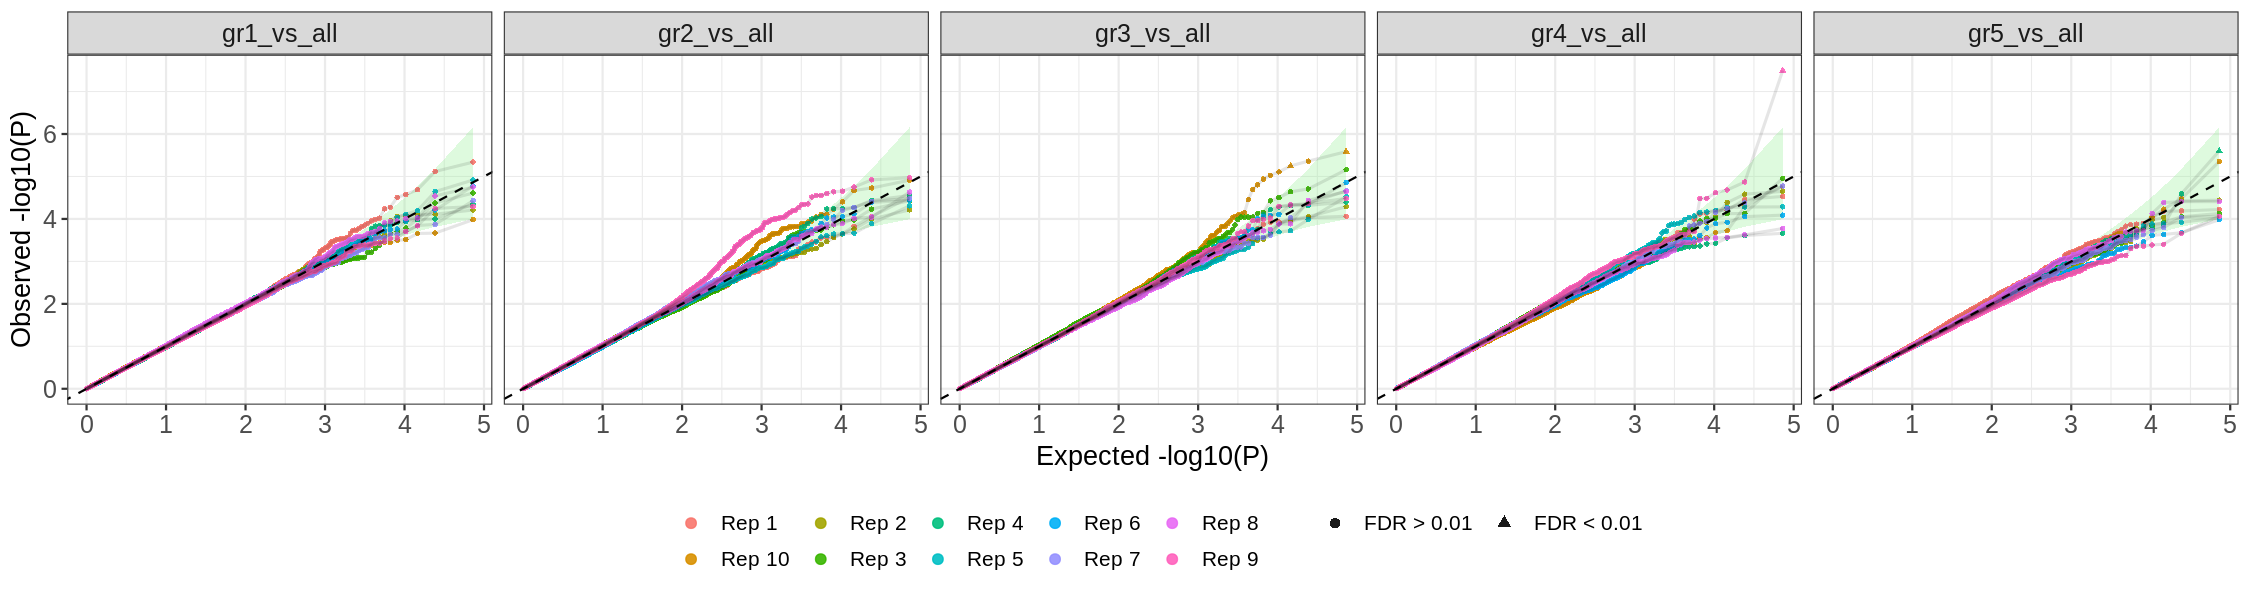

In [40]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 150)

n_el <- sum(cl_genes$comp == comp[1])
n <- n_el
conf.alpha <- 0.05

data_random <- cl_genes_r %>% group_by(rep, comp) %>% 
    mutate(obs_logp = -log10(pval)) %>% 
    arrange(obs_logp,.by_group = TRUE)
exp_values <- sort(-log10(ppoints(n_el)))
data_random <- data_random %>% mutate(exp_logp = exp_values) %>% ungroup()
data_random$sign <- 'FDR > 0.01'
data_random$sign[data_random$pval_corr <= 0.01] <- 'FDR < 0.01'
data_random$sign <- factor(data_random$sign, levels = c('FDR > 0.01', 'FDR < 0.01'))
data_random$repetition <- factor(data_random$rep)

conf.points = min(4000, n-1);
mpts<-matrix(nrow=conf.points*2, ncol=2)
for(i in seq(from=1, to=conf.points)) {
        mpts[i,1]<- -log10((i-.5)/n)
        mpts[i,2]<- -log10(qbeta(1-conf.alpha/2, i, n-i))
        mpts[conf.points*2+1-i,1]<- -log10((i-.5)/n)
        mpts[conf.points*2+1-i,2]<- -log10(qbeta(conf.alpha/2, i, n-i))
}
mpts <- data.frame(x = mpts[,1], y = mpts[,2])

pl <- ggplot(data=data_random, aes(x=exp_logp, y=obs_logp, group = repetition)) +
       geom_polygon(data = mpts, aes(x = x, y = y, group = NA), 
                   fill = 'lightgreen', alpha = 0.3)+
      geom_point(size = 0.9, alpha = 0.9, aes(shape=sign, color = repetition))+
      geom_line(size = 0.7, alpha = 0.1)+
      geom_abline(slope = 1, intercept = 0, color = 'black', linetype = 2)+
      xlab('Expected -log10(P)')+ylab('Observed -log10(P)')+
      facet_wrap(.~comp, nrow = 1)+
      theme_bw()+theme(strip.text = element_text(size=12),
                      legend.position = "bottom",
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12))+
      guides(color = guide_legend(override.aes = list(size = 2)), 
           shape = guide_legend(override.aes = list(size = 2)))

pl
pl <- ggplot_gtable(ggplot_build(pl))
stripr <- which(grepl('strip-t', pl$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}
ggsave(filename = sprintf('%s/genesP_qqplot_randomCL.png', out_fold), width = 15, height = 4.2, dpi = 300, plot = pl, device = 'png')
  

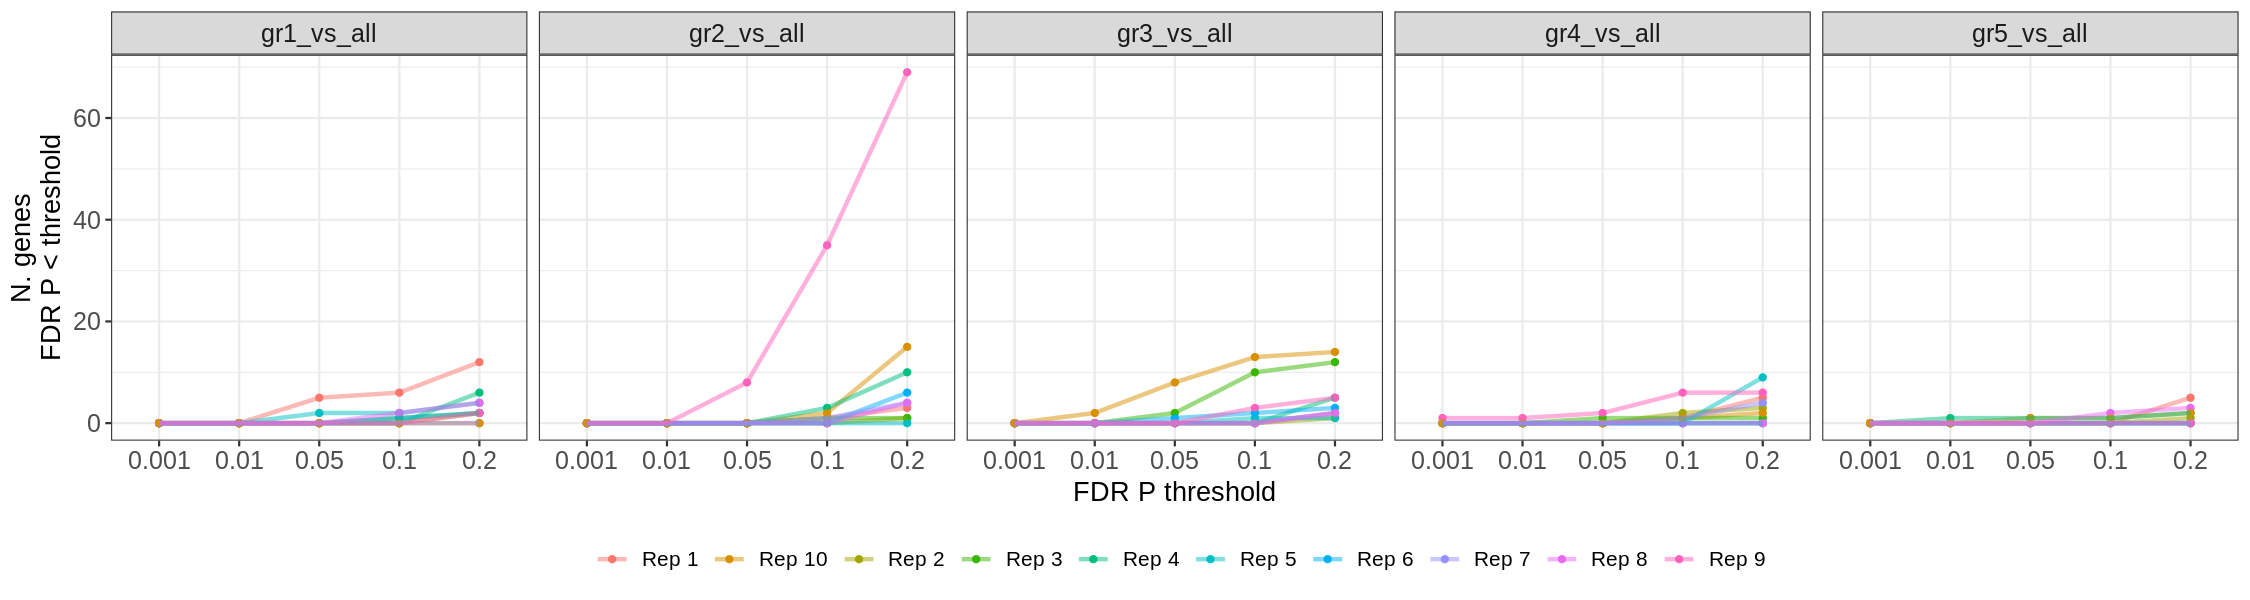

In [41]:
# count differences
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 150)

convert_to_count <- function(feat_df, id_comp){
    
    thr <- c(0, 1e-150, 1e-50, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4)
    thr_FDR <- c(0.001, 0.01, 0.05, 0.1, 0.2)
    feat_df <- feat_df[feat_df$comp == id_comp,]
    df_thr <- data.frame(thr = thr, count = sapply(thr, function(x) sum(feat_df$pval <= x)), comp = id_comp)
    df_thr_FDR <- data.frame(thr = thr_FDR, count = sapply(thr_FDR, function(x) sum(feat_df$pval_corr <= x)), 
                                                           comp = id_comp)
                                                           
    return(list(pval = df_thr, pval_corr = df_thr_FDR))
    
}


        
count_thr_pval_r <- count_thr_pval_FDR_r <- list()
for(i in 1:n_rep_short){
    
    feat_df <- cl_genes_r[cl_genes_r$rep == sprintf("Rep %i", i),]
    tmp <- lapply(comp, function(x) convert_to_count(feat_df,x))
    count_thr_pval_r[[i]] <- do.call(rbind, lapply(tmp, function(x) x$pval))
    count_thr_pval_r[[i]]$rep <- sprintf("Rep %i", i)
    count_thr_pval_FDR_r[[i]] <- do.call(rbind, lapply(tmp, function(x) x$pval_corr))
    count_thr_pval_FDR_r[[i]]$rep <- sprintf("Rep %i", i)
}

count_thr_pval_r <- do.call(rbind, count_thr_pval_r)
count_thr_pval_FDR_r <- do.call(rbind, count_thr_pval_FDR_r)
thr_values <- c(0, 1e-150, 1e-50, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4)
count_thr_pval_r$thr <- factor(as.character(count_thr_pval_r$thr), 
                               levels = as.character(thr_values))

pl <- ggplot(data=count_thr_pval_FDR_r, aes(x=as.character(thr), y=count, 
                                            group=rep, color = rep)) +
      geom_point(size = 1.2, alpha = 1)+
      geom_line(size = 1, alpha = 0.5)+
      xlab('FDR P threshold')+
      ylab('N. genes\nFDR P < threshold')+
      facet_wrap(.~comp, nrow = 1)+
      theme_bw()+theme(legend.position = "bottom",
                       strip.text = element_text(size = 12),
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12))+
    guides(colour = guide_legend(nrow = 1))
pl
pl <- ggplot_gtable(ggplot_build(pl))
stripr <- which(grepl('strip-t', pl$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}
ggsave(filename = sprintf('%s/genesP_FDRthrCount_randomCL.pdf', out_fold), width = 15, height = 4.2, plot = pl, device = 'pdf')
  
                                                       

In [42]:
cl_genes_r[cl_genes_r$pval_corr <= 0.01,]
lapply(comp, function(x) count_thr_pval_FDR_r[count_thr_pval_FDR_r$comp == x & count_thr_pval_FDR_r$thr == 0.01,]) 
sapply(comp, function(x) sum(count_thr_pval_FDR_r$count[count_thr_pval_FDR_r$comp == x & count_thr_pval_FDR_r$thr == 0.01] > 0)) 

,feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,rep
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
653313,ST6GALNAC2,gr5_vs_all,2.50e-06,0.15580705,0.09053492,0.22410718,6.69000e-03,0.0334500000,Colon_Sigmoid,Rep 4
1546709,UFSP2,gr4_vs_all,3.21e-08,-0.08864731,-0.12025678,-0.05715737,6.60297e-05,0.0003301485,Artery_Coronary,Rep 9
1752214,NFYC,gr3_vs_all,2.60e-06,-0.09698600,-0.13735585,-0.05647552,8.45260e-03,0.0422630000,Colon_Transverse,Rep 10
1752448,FAM228A,gr3_vs_all,5.64e-06,-0.03487248,-0.05306852,-0.01915381,9.16782e-03,0.0458391000,Colon_Transverse,Rep 10


,thr,count,comp,rep
,<dbl>,<int>,<chr>,<chr>
2,0.01,0,gr1_vs_all,Rep 1
27,0.01,0,gr1_vs_all,Rep 2
52,0.01,0,gr1_vs_all,Rep 3
77,0.01,0,gr1_vs_all,Rep 4
102,0.01,0,gr1_vs_all,Rep 5
127,0.01,0,gr1_vs_all,Rep 6
152,0.01,0,gr1_vs_all,Rep 7
177,0.01,0,gr1_vs_all,Rep 8
202,0.01,0,gr1_vs_all,Rep 9


gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all gr5_vs_all 
         0          0          1          1          1

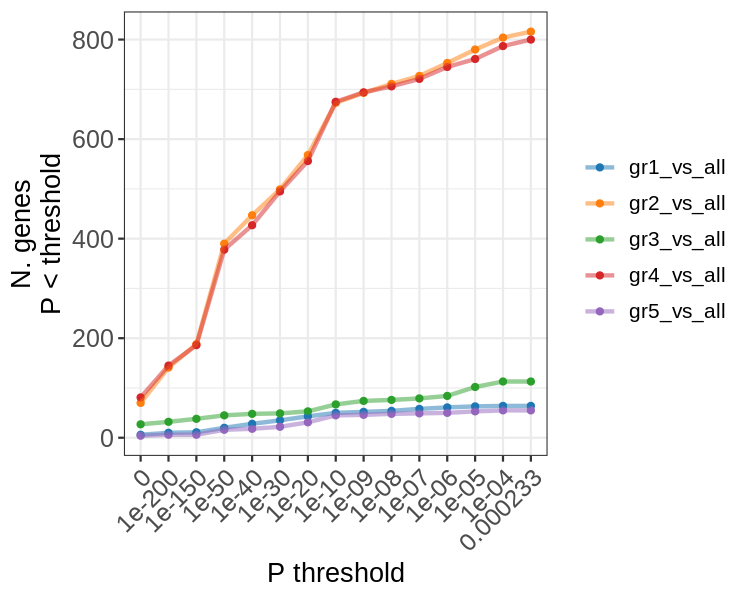

In [43]:
# actual number for clustering:

options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 150)

cl_genes_sign <- cl_genes[cl_genes$pval_corr <= 0.01, ]
thr_values <- c(0, 1e-200, 1e-150, 1e-50, 1e-40,1e-30, 1e-20,  
         1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, max(cl_genes_sign$pval))
tmp <- unlist(lapply(thr_values, function(x) 
              lapply(comp, function(y) sum(cl_genes_sign$pval <= x & cl_genes_sign$comp == y))))
count_thr_pval <- data.frame(count = tmp, comp = rep(comp, length(thr_values)), 
                             thr = unlist(lapply(thr_values, function(x) rep(x, length(comp)))))                                 
count_thr_pval$thr <- factor(as.character(count_thr_pval$thr), 
                               levels = as.character(thr_values))

pl <- ggplot(data=count_thr_pval, aes(x=thr, y=count, group = comp, color = comp)) +
      geom_point(size = 1.2, alpha = 1)+
      geom_line(size = 1, alpha = 0.5)+
      xlab('P threshold')+
      ylab('N. genes\nP < threshold')+
      scale_color_manual(values = gr_color)+
      theme_bw()+theme(legend.position = "right",
                       strip.text = element_text(size = 12),
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12), axis.text.x = element_text(angle = 45, hjust = 1))
pl
ggsave(filename = sprintf('%s/genesP_FDRthr0.01_count.pdf', out_fold), width = 5, height = 4.2,  plot = pl, device = 'pdf')



Conclusion on the genes:
- the p-value distribution is not strictly uniform but not deviate much from the expected one (combined for tissues but separated for groups) (QQplot)
- at FDR 0.01, at max 2 sign results in 1 out of 10 repetitions (count plot) and only in 3 groups
- consider FDR 0.01 as gene threshold, P-value count shown for each group separately

In [44]:
# compare pathway relevance with random one

cl_path_r <- list()
n_rep_short <- 10
for(i in 1:n_rep_short){

    print(i)
    cl_path_r[[i]] <- get(load(sprintf('%srep%i_pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', 
                                      fold_random, i)))
    cl_path_r[[i]]  <- do.call(rbind, cl_path_r[[i]]$test_feat)
    cl_path_r[[i]]$rep <- sprintf("Rep %i", i)
    
}

cl_path_r <- do.call(rbind, cl_path_r)


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


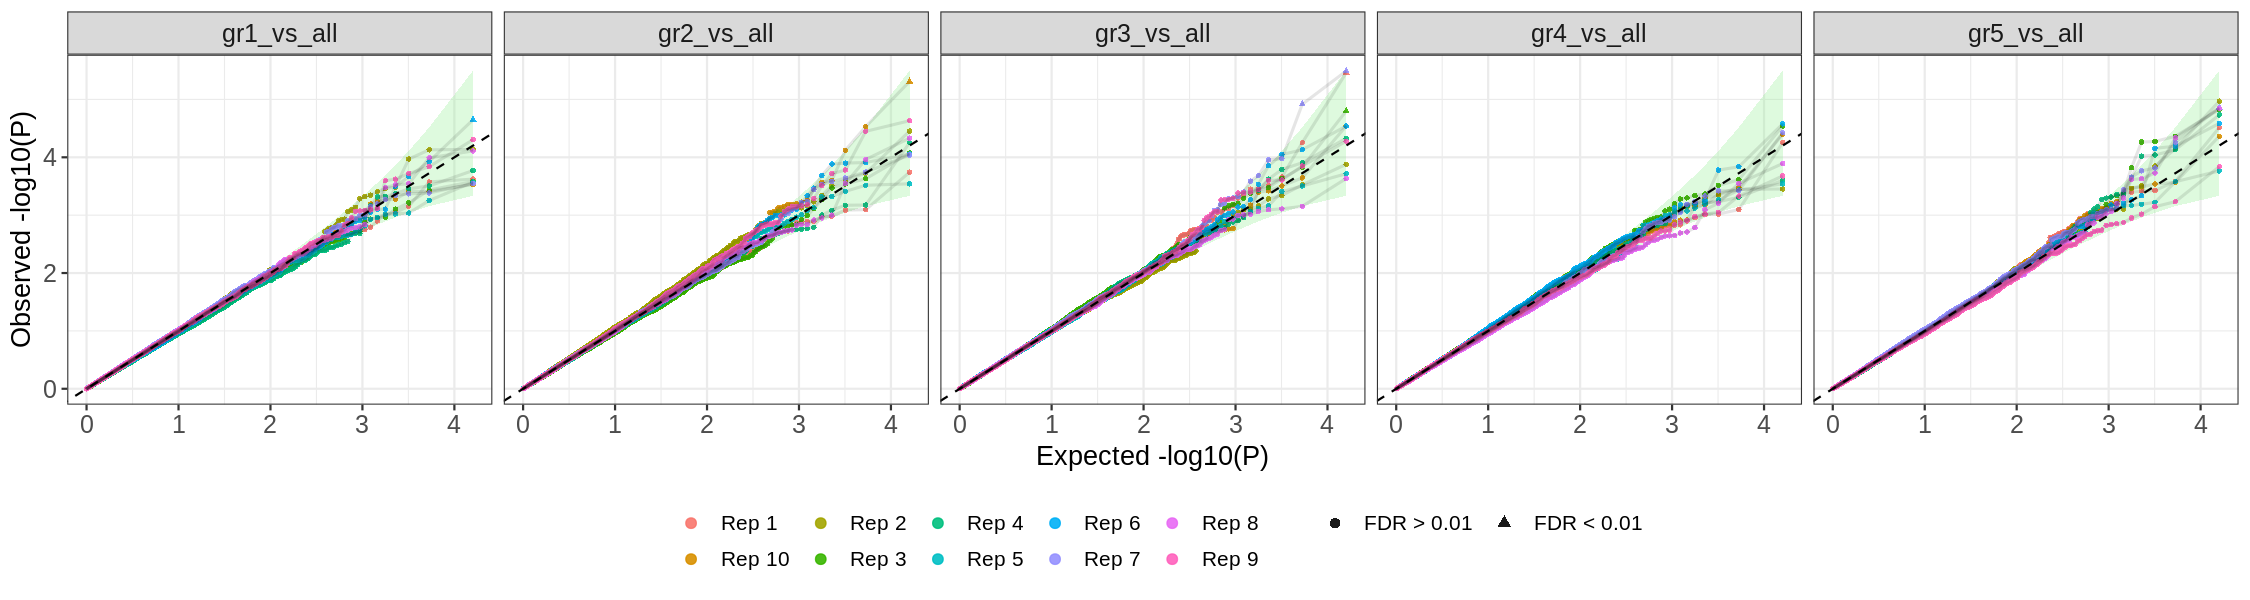

In [45]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 150)

n_el <- sum(cl_pathways$comp == comp[1])
n <- n_el
conf.alpha <- 0.05

data_random <- cl_path_r %>% group_by(rep, comp) %>% 
    mutate(obs_logp = -log10(pval)) %>% 
    arrange(obs_logp,.by_group = TRUE)
exp_values <- sort(-log10(ppoints(n_el)))
data_random <- data_random %>% mutate(exp_logp = exp_values) %>% ungroup()
data_random$sign <- 'FDR > 0.01'
data_random$sign[data_random$pval_corr <= 0.01] <- 'FDR < 0.01'
data_random$sign <- factor(data_random$sign, levels = c('FDR > 0.01', 'FDR < 0.01'))
data_random$repetition <- factor(data_random$rep)

conf.points = min(4000, n-1);
mpts<-matrix(nrow=conf.points*2, ncol=2)
for(i in seq(from=1, to=conf.points)) {
        mpts[i,1]<- -log10((i-.5)/n)
        mpts[i,2]<- -log10(qbeta(1-conf.alpha/2, i, n-i))
        mpts[conf.points*2+1-i,1]<- -log10((i-.5)/n)
        mpts[conf.points*2+1-i,2]<- -log10(qbeta(conf.alpha/2, i, n-i))
}
mpts <- data.frame(x = mpts[,1], y = mpts[,2])
pl <- ggplot(data=data_random, aes(x=exp_logp, y=obs_logp, group = repetition)) +
       geom_polygon(data = mpts, aes(x = x, y = y, group = NA), 
                   fill = 'lightgreen', alpha = 0.3)+
      geom_point(size = 0.9, alpha = 0.9, aes(shape=sign, color = repetition))+
      geom_line(size = 0.7, alpha = 0.1)+
      geom_abline(slope = 1, intercept = 0, color = 'black', linetype = 2)+
      xlab('Expected -log10(P)')+ylab('Observed -log10(P)')+
      facet_wrap(.~comp, nrow = 1)+
      theme_bw()+theme(strip.text = element_text(size=12),
                      legend.position = "bottom",
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12))+
      guides(color = guide_legend(override.aes = list(size = 2)), 
           shape = guide_legend(override.aes = list(size = 2)))
pl
pl <- ggplot_gtable(ggplot_build(pl))
stripr <- which(grepl('strip-t', pl$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}
ggsave(filename = sprintf('%s/pathwayP_qqplot_randomCL.png', out_fold), width = 15, height = 4.2, dpi = 300, plot = pl, device = 'png')
  

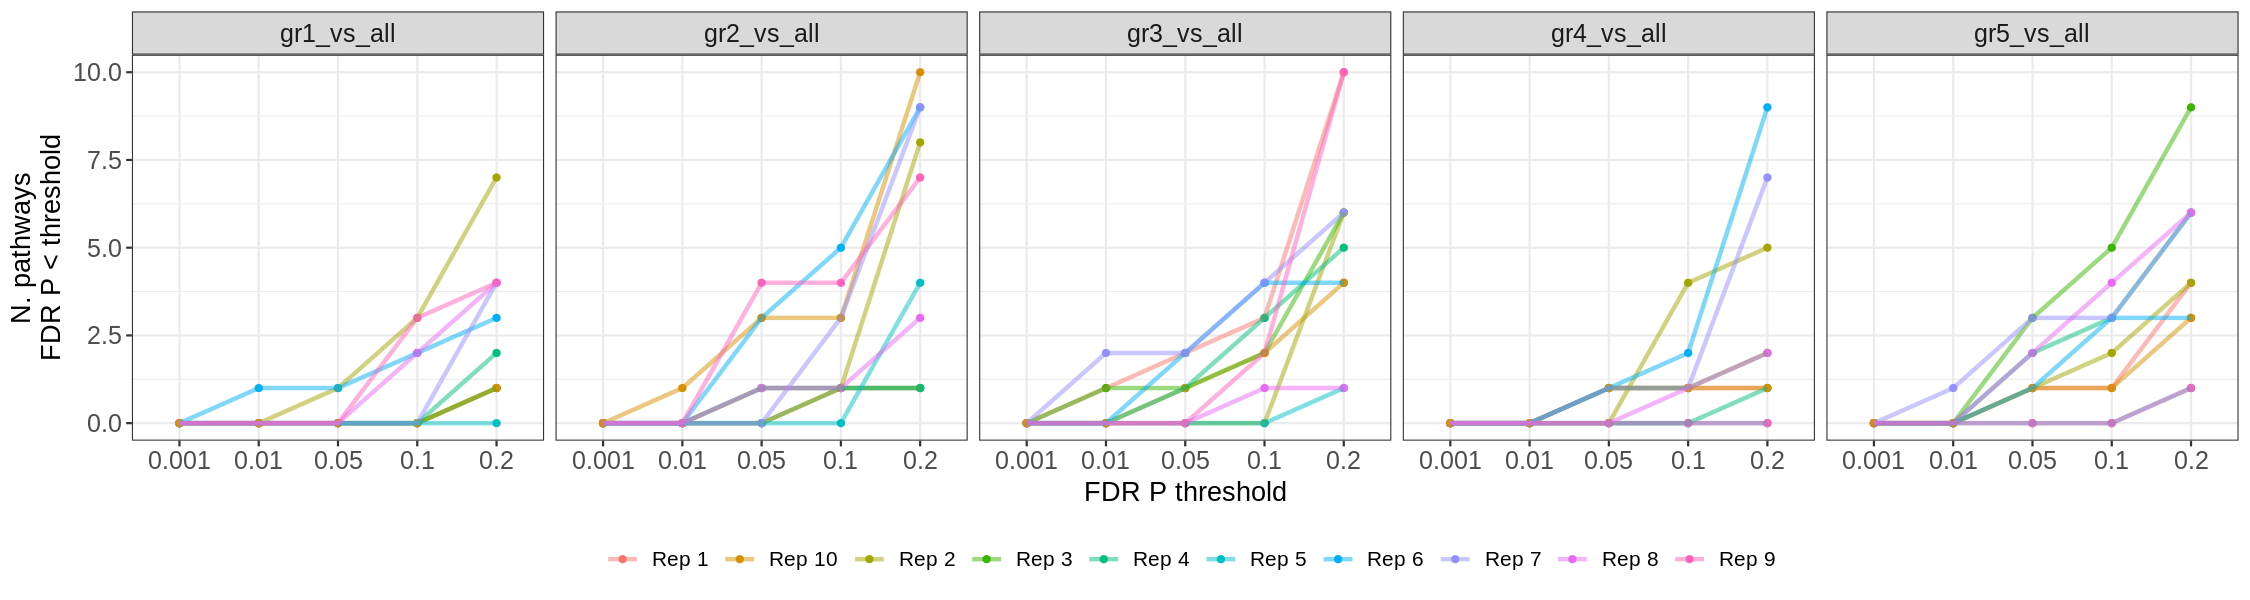

In [46]:
count_thr_pval_r <- count_thr_pval_FDR_r <- list()
for(i in 1:n_rep_short){
    
    feat_df <- cl_path_r[cl_path_r$rep == sprintf("Rep %i", i),]
    tmp <- lapply(comp, function(x) convert_to_count(feat_df,x))
    count_thr_pval_r[[i]] <- do.call(rbind, lapply(tmp, function(x) x$pval))
    count_thr_pval_r[[i]]$rep <- sprintf("Rep %i", i)
    count_thr_pval_FDR_r[[i]] <- do.call(rbind, lapply(tmp, function(x) x$pval_corr))
    count_thr_pval_FDR_r[[i]]$rep <- sprintf("Rep %i", i)
}

count_thr_pval_r <- do.call(rbind, count_thr_pval_r)
count_thr_pval_FDR_r <- do.call(rbind, count_thr_pval_FDR_r)
thr_values <- c(0, 1e-150, 1e-50, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4)
count_thr_pval_r$thr <- factor(as.character(count_thr_pval_r$thr), 
                               levels = as.character(thr_values))

pl <- ggplot(data=count_thr_pval_FDR_r, aes(x=as.character(thr), y=count, 
                                            group=rep, color = rep)) +
      geom_point(size = 1.2, alpha = 1)+
      geom_line(size = 1, alpha = 0.5)+
      xlab('FDR P threshold')+
      ylab('N. pathways\nFDR P < threshold')+
      facet_wrap(.~comp, nrow = 1)+
      theme_bw()+theme(legend.position = "bottom",
                       strip.text = element_text(size = 12),
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12))+
    guides(colour = guide_legend(nrow = 1))
pl
pl <- ggplot_gtable(ggplot_build(pl))
stripr <- which(grepl('strip-t', pl$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}
ggsave(filename = sprintf('%s/pathwayP_FDRthrCount_randomCL.pdf', out_fold), width = 15, height = 4.2, plot = pl, device = 'pdf')
  
                                                       

In [47]:
cl_path_r[cl_path_r$pval_corr <= 0.01,]
lapply(comp, function(x) count_thr_pval_FDR_r[count_thr_pval_FDR_r$comp == x & count_thr_pval_FDR_r$thr == 0.01,]) 
sapply(comp, function(x) sum(count_thr_pval_FDR_r$count[count_thr_pval_FDR_r$comp == x & count_thr_pval_FDR_r$thr == 0.01] > 0)) 

,feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,rep
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
37547,5'-nucleotidase activity,gr3_vs_all,3.48e-06,0.09648408,0.05566818,0.13717807,0.00314592,0.01572960,Whole_Blood,Rep 1
108188,melanin biosynthetic process,gr3_vs_all,1.59e-05,0.08904898,0.04862321,0.12952446,0.00785460,0.03927300,Heart_Atrial_Appendage,Rep 3
233143,positive regulation of inflammatory response,gr1_vs_all,2.24e-05,0.06763307,0.03628344,0.09926803,0.00920640,0.04603200,Liver,Rep 6
255691,cellular response to gonadotropin stimulus,gr3_vs_all,3.23e-06,0.09715461,0.05628561,0.13805835,0.00368543,0.01842715,Artery_Aorta,Rep 7
268567,methyltransferase activity,gr5_vs_all,1.38e-05,0.16184695,0.08902779,0.23469081,0.00681720,0.03408600,Heart_Atrial_Appendage,Rep 7
270569,mitochondrial small ribosomal subunit,gr3_vs_all,1.21e-05,-0.09166125,-0.13268459,-0.05066807,0.00925650,0.04628250,Heart_Left_Ventricle,Rep 7
396075,leukocyte migration,gr2_vs_all,4.89e-06,0.07839988,0.04478901,0.11207560,0.00442056,0.02210280,Whole_Blood,Rep 10


,thr,count,comp,rep
,<dbl>,<int>,<chr>,<chr>
2,0.01,0,gr1_vs_all,Rep 1
27,0.01,0,gr1_vs_all,Rep 2
52,0.01,0,gr1_vs_all,Rep 3
77,0.01,0,gr1_vs_all,Rep 4
102,0.01,0,gr1_vs_all,Rep 5
127,0.01,1,gr1_vs_all,Rep 6
152,0.01,0,gr1_vs_all,Rep 7
177,0.01,0,gr1_vs_all,Rep 8
202,0.01,0,gr1_vs_all,Rep 9


gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all gr5_vs_all 
         1          1          3          0          1

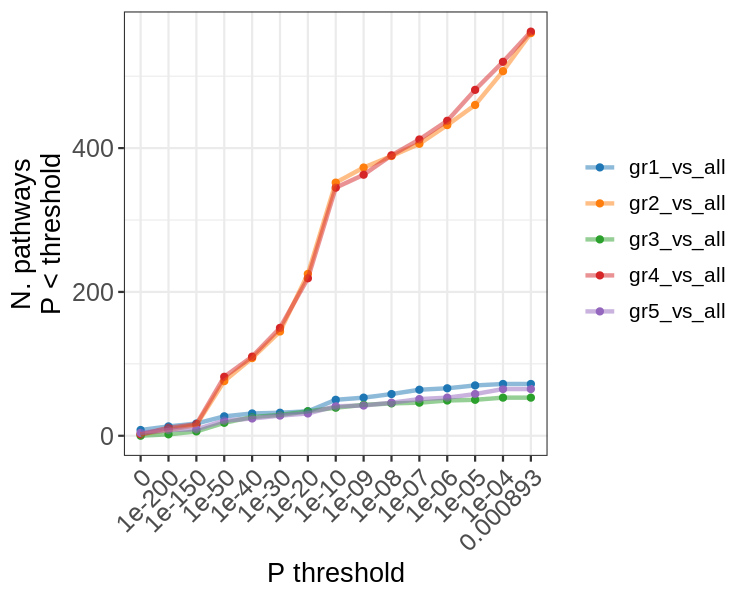

In [48]:
# actual number for clustering:

options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 150)

cl_pathways_sign <- cl_pathways[cl_pathways$pval_corr <= 0.01, ]
thr_values <- c(0, 1e-200, 1e-150, 1e-50, 1e-40,1e-30, 1e-20,  
         1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, max(cl_pathways_sign$pval))
tmp <- unlist(lapply(thr_values, function(x) 
              lapply(comp, function(y) sum(cl_pathways_sign$pval <= x & cl_pathways_sign$comp == y))))
count_thr_pval <- data.frame(count = tmp, comp = rep(comp, length(thr_values)), 
                             thr = unlist(lapply(thr_values, function(x) rep(x, length(comp)))))                                 
count_thr_pval$thr <- factor(as.character(count_thr_pval$thr), 
                               levels = as.character(thr_values))

pl <- ggplot(data=count_thr_pval, aes(x=thr, y=count, group = comp, color = comp)) +
      geom_point(size = 1.2, alpha = 1)+
      geom_line(size = 1, alpha = 0.5)+
      xlab('P threshold')+
      ylab('N. pathways\nP < threshold')+
      scale_color_manual(values = gr_color)+
      theme_bw()+theme(legend.position = "right",
                       strip.text = element_text(size = 12),
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12), axis.text.x = element_text(angle = 45, hjust = 1))
pl
ggsave(filename = sprintf('%s/pathwayP_FDRthr0.01_count.pdf', out_fold), width = 5, height = 4.2,  plot = pl, device = 'pdf')


Similar for pathways, mostly follows a uniform distribution. One rep is sign at FDR 0.01 for 3 groups and 3 reps are significant in gr3 with at max 2 values. 